# 1. Preprocessing

In [37]:

import numpy as np
from sklearn.base import BaseEstimator
from sklearn.neighbors import KDTree
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import RadiusNeighborsClassifier
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import operator
import scipy as sp
from sklearn import preprocessing
import json
import pandas as pd
from scipy.stats import gamma
from math import log2

In [38]:
data_location_AT = [r"/content/drive/MyDrive/research/data/ATER",
                 r"/content/drive/MyDrive/research/data/ATERDD",
                 r"/content/drive/MyDrive/research/data/ATGEO",
                 r"/content/drive/MyDrive/research/data/ATGEOGD",
                 r"/content/drive/MyDrive/research/data/ATHGG",
                 r"/content/drive/MyDrive/research/data/ATSF",
                 r"/content/drive/MyDrive/research/data/ATSFDD",
                 r"/content/drive/MyDrive/research/data/ATSticky",
                 r"/content/drive/MyDrive/research/data/ATOriginal"]

In [39]:
ER = normalize(pd.read_csv(data_location_AT[0], header = None, sep = ' '))
ER


array([[2.23436983e-03, 1.64236300e-02, 4.05983786e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.26331923e-03, 1.65672609e-02, 3.62887958e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.24196159e-03, 1.64492158e-02, 4.16757237e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.15451052e-03, 1.60291722e-02, 3.88484457e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.25410716e-03, 1.65244707e-02, 4.46268202e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.24464358e-03, 1.64767428e-02, 3.85071093e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

# 2. Setup Functions

In [40]:
def gamma_points(num,shape=None,scale=None,random=True):
    """
    num: # of points generated
    shape, scale: need to be specified if random is False, generating a fixed-value gamma
    random: default=True: generating <num> random points from a gamma with random shape and scale.
    Return the paramters of the gamma, the Gamma object itself, and the a Sorted List of randomly generated points
    """
    if random:
        r = np.random.rand(1,2)
        shape,scale = r[0][0]*5,r[0][1]*20    # generating random parameters. To be refined.
    #print("Shape: {}, Scale: {}".format(shape,scale))
    Gamma = gamma(a=shape,scale=scale)
    s = Gamma.rvs(num)
    s = s.tolist()
    s.sort()
    return shape,scale,Gamma, s

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
def smallest_in_arr(euclid_list):
  small_arr = []
  smallest = 99;
  for array in euclid_list:
    small_arr.append(min(array))
  return small_arr

In [43]:
#euclidean distance formula
def euclid(origin, other):
  return np.sum((origin - other) ** 2)**(1/2)

#find euclidean distances between all points and return it as an array
#takes a row and finds euclidean distance between this row and every other row in the dataframe
#(skips itself; if distance with itself will be 0)
def find_distances(df_vals):
  euclid_list = []
  for reference_row in df_vals:
    reference_dists = []
    for other_row in df_vals:
      euclid_dist = euclid(reference_row, other_row)
      if euclid_dist == 0:
        continue
      else:
        reference_dists.append(euclid_dist)
    euclid_list.append(reference_dists)
  return euclid_list

In [44]:
# calculate the kl divergence
def kl_divergence(a, b):
	a = np.asarray(a, dtype=np.float)
	b = np.asarray(b, dtype=np.float)
	return np.sum(np.where(a != 0, a * np.log(a / b), 0))
  

In [48]:
def KL_gridSearch(num_points,shape, scale, empirical_nearest):
  max_score = 100000
  count = 0
  for i in shape_params:
    for j in scale_params:
      shape,scale,Gamma,sample= gamma_points(num_points,i,j,False)
      sample_nearest = sample/np.sum(sample)
      current_score = kl_divergence(sample_nearest, empirical_nearest)
      count = count + 1
      if current_score < max_score:
        max_score = current_score
        best_scale = scale
        best_shape = shape
        print("count:", count, "shape:", shape, "scale:", scale, "score:", current_score)
  return max_score, best_shape, best_scale

In [49]:
shape_params = np.arange(3,7)
scale_params = np.logspace(1,100,100)
points = prob_nearest.shape[0]
KL_score, best_shape, best_scale = KL_gridSearch(points,shape_params, scale_params, prob_nearest)
print(best_shape, best_scale)

count: 1 shape: 3 scale: 10.0 score: 0.2397200059291379
count: 25 shape: 3 scale: 1e+25 score: 0.2396403999997671
count: 36 shape: 3 scale: 1e+36 score: 0.23878741219927477
count: 94 shape: 3 scale: 1e+94 score: 0.2375626622269067
count: 101 shape: 4 scale: 10.0 score: 0.2087906115093442
count: 107 shape: 4 scale: 10000000.0 score: 0.20823434384638795
count: 109 shape: 4 scale: 1000000000.0 score: 0.20640979231938922
count: 129 shape: 4 scale: 1e+29 score: 0.20558422517809777
count: 134 shape: 4 scale: 1e+34 score: 0.20017104727140858
count: 201 shape: 5 scale: 10.0 score: 0.1927428880704534
count: 205 shape: 5 scale: 100000.0 score: 0.18461484914599735
count: 223 shape: 5 scale: 1e+23 score: 0.18156900043215538
count: 228 shape: 5 scale: 1e+28 score: 0.1797926445229625
count: 257 shape: 5 scale: 1e+57 score: 0.17802528820520352
count: 301 shape: 6 scale: 10.0 score: 0.16967438238814075
count: 304 shape: 6 scale: 10000.0 score: 0.16934093228785357
count: 308 shape: 6 scale: 100000000.0

In [56]:
def random_avger(points,shape, scale):
  zero_list = np.zeros(points)
  for i in range(10):
    shape,scale,Gamma,sample= gamma_points(points,shape,scale,False)
    sample = sample/np.sum(sample)
    zero_list = np.add(zero_list, sample)
  zero_list = zero_list/10
  return zero_list

# 3. Fitting

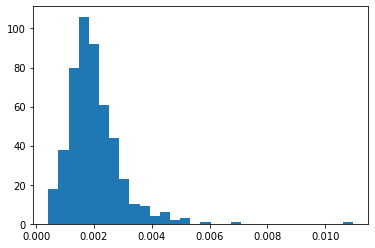

In [47]:
sample_nearest = np.asarray(smallest_in_arr(find_distances(ER)))
prob_nearest = sample_nearest/sum(sample_nearest)
plt.hist(prob_nearest, bins = 30)
plt.show()

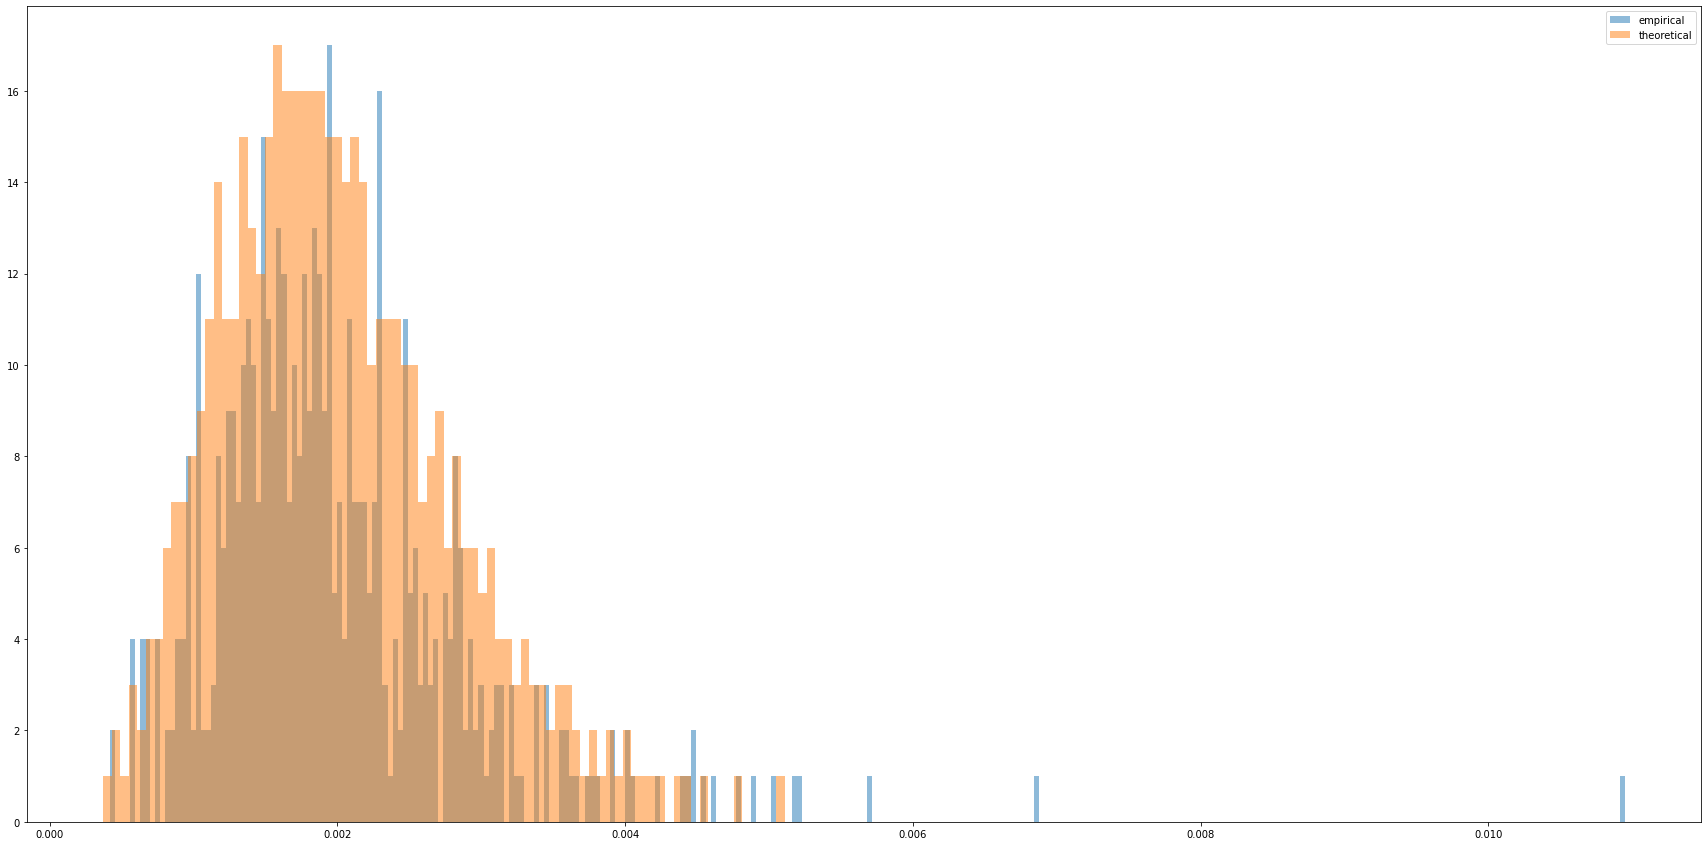

In [57]:
zero_list = random_avger(points,best_shape,best_scale)
fig, ax = plt.subplots(1,1, figsize = (30,15))
ax.hist(prob_nearest, bins = 300, alpha = 0.5, label = "empirical")
ax.hist(zero_list, bins = 80, alpha = 0.5, label = "theoretical")
plt.legend()
plt.show()

In [51]:
print("area of empirical:", sp.integrate.simps(prob_nearest))
print("area of theoretical:", sp.integrate.simps(zero_list))

area of empirical: 0.9895979771304608
area of theoretical: 0.9970575466945713


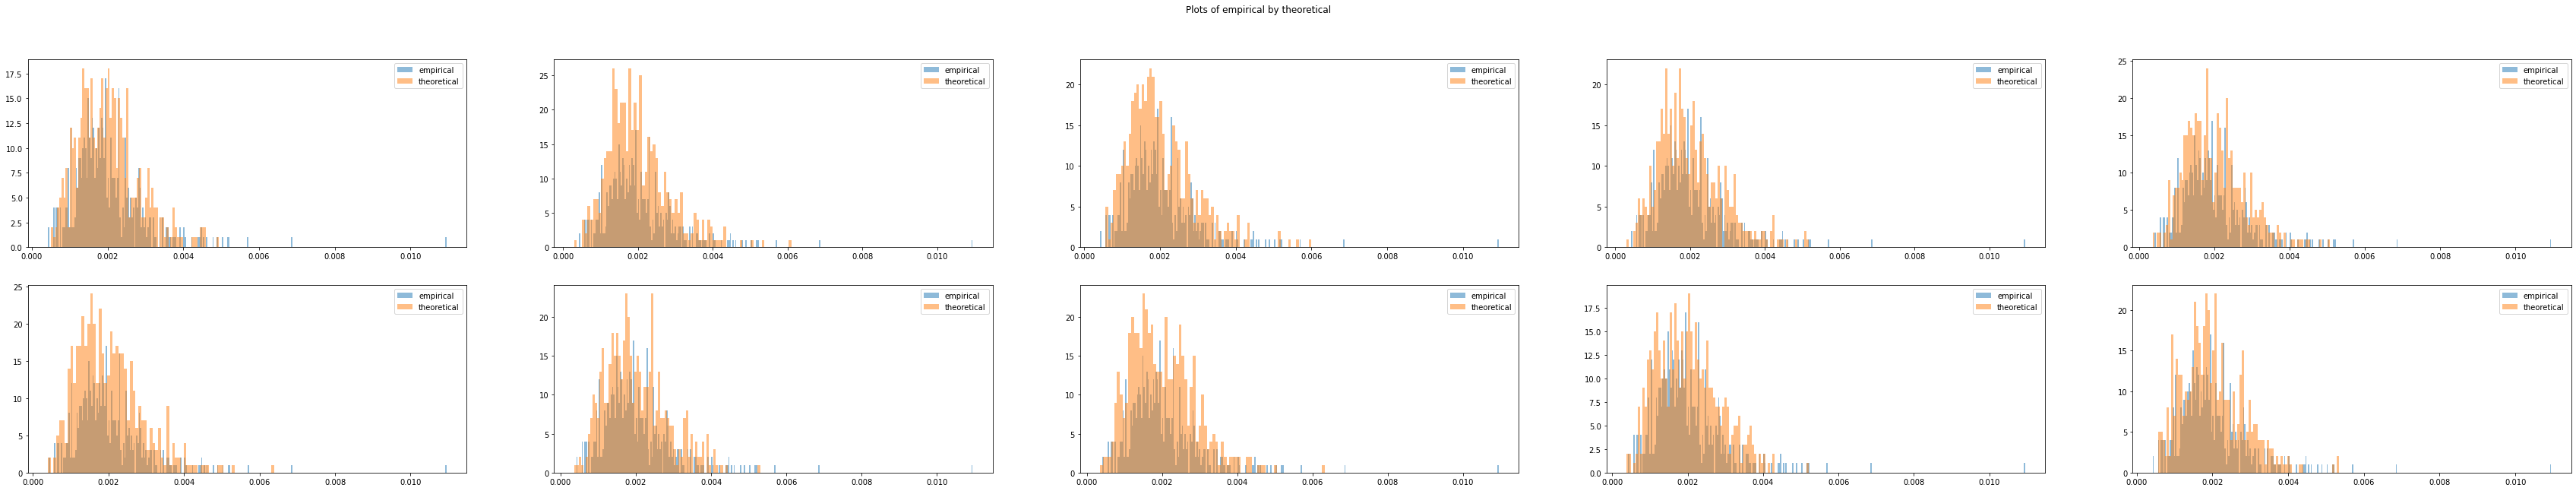

In [52]:
def subplots(best_shape, best_scale):
  fig, ax = plt.subplots(2,5, figsize = (60,10))
  ax = ax.flatten()
  fig.suptitle("Plots of empirical by theoretical")
  for i in np.arange(10):
    ax[i].hist(prob_nearest, bins = 300, alpha = 0.5, label = "empirical")

    shape,scale,Gamma,sample= gamma_points(499,best_shape,best_scale,False)
    sample = sample/np.sum(sample)
    ax[i].hist(sample, bins = 80, alpha = 0.5, label = "theoretical")
    ax[i].legend()

subplots(best_shape, best_scale)

In [53]:
low_shape = random_avger(points,best_shape, best_scale)
high_shape = random_avger(points,99, best_scale)
print("low shape entropy:", sp.stats.entropy(low_shape, prob_nearest))
print("high shape entopy:", sp.stats.entropy(high_shape, prob_nearest))
print("low shape kl divergence:", kl_divergence(low_shape, prob_nearest))
print("high shape kl divergence:", kl_divergence(high_shape, prob_nearest))

low shape entropy: 0.17695553763342997
high shape entopy: 0.09811694723846791
low shape kl divergence: 0.17695553763343064
high shape kl divergence: 0.09811694723846857


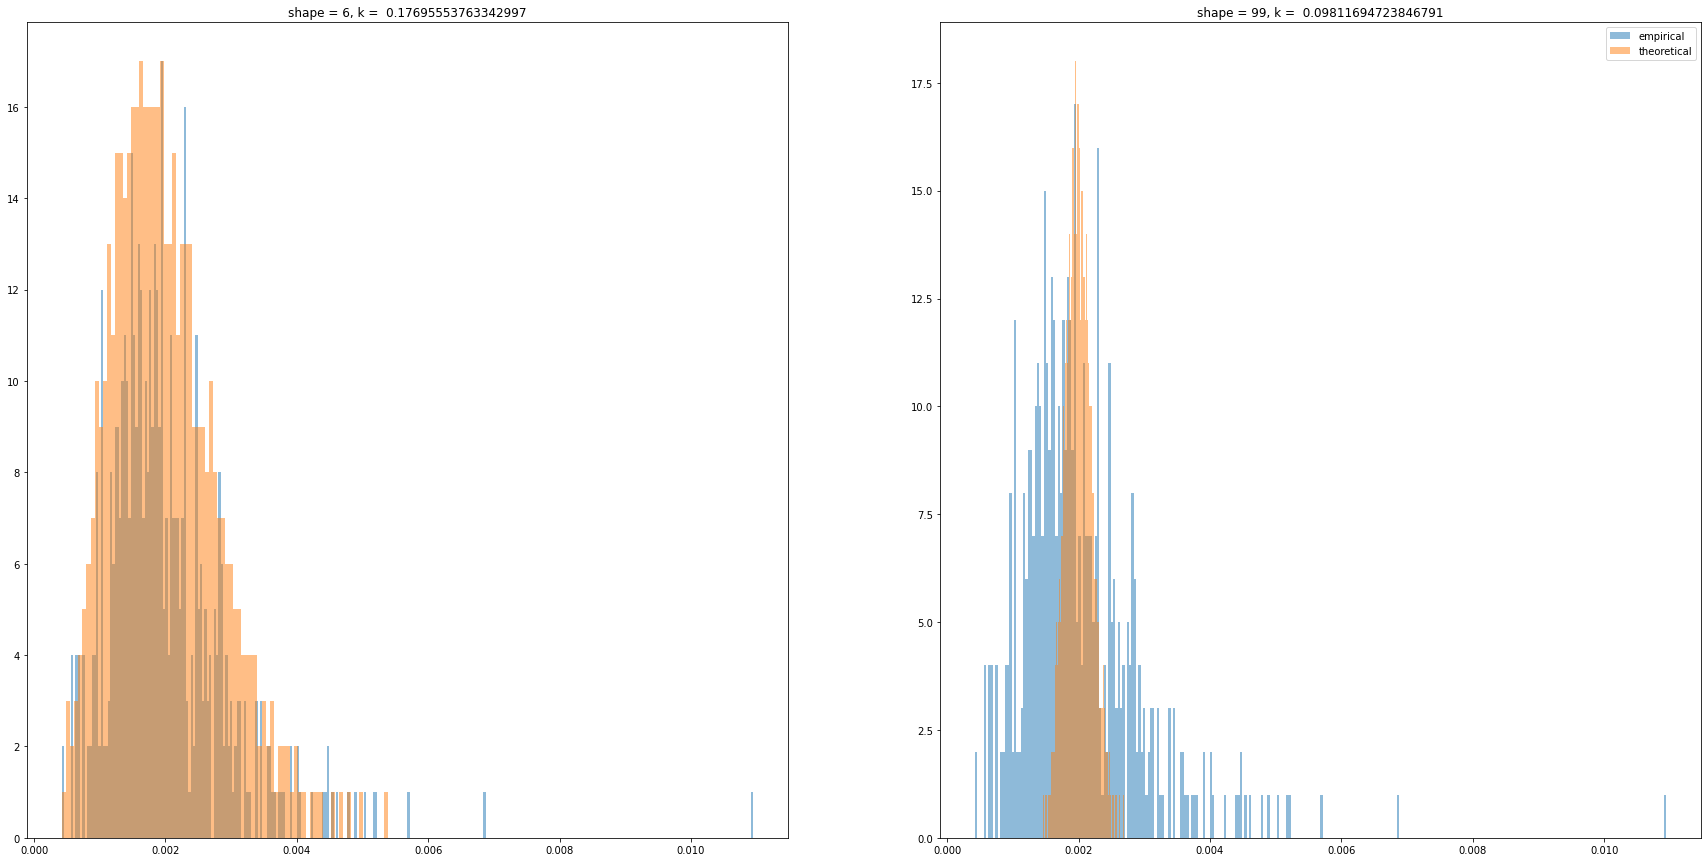

In [59]:
fig, ax = plt.subplots(1,2, figsize = (30,15))
ax[0].hist(prob_nearest, bins = 300, alpha = 0.5, label = "empirical")
ax[0].hist(low_shape, bins = 80, alpha = 0.5, label = "theoretical")
ax[0].title.set_text("shape = 6, k =  0.17695553763342997")

ax[1].hist(prob_nearest, bins = 300, alpha = 0.5, label = "empirical")
ax[1].hist(high_shape, bins = 80, alpha = 0.5, label = "theoretical")
ax[1].title.set_text("shape = 99, k =  0.09811694723846791")


plt.legend()
plt.show()

In [55]:
print(euclid(low_shape, prob_nearest))
print(euclid(high_shape, prob_nearest))

0.028226195263274762
0.021695058517520082
